This was my "working draft" version of this project. Am in the middle of using this to create my Final version cleaned/consolidated in other notebook.

This project will look at historical short interest rates of S&P 500 stocks to see what (if any) correlations have existed between the level of short interest and future returns.

My interest in this arose today reading about the all-time high short ratios for the S&P500 ETF being reached last week. The article made this sound like a negative trend, and listed historicaly short ratios (though, the data for the ETF only went back 3 years, so not really a great sample size).

I'm curious how a high level of short interest has correlated with future returns over the next 6 to 24 month periods.

I've been playing around with learning how to scrape stock and other financial data from the web so this will be a great opportunity to put some of that learning into practice.

NOTE TO SELF - If/When I turn this into a portfolio project: make a new copy and take out a lot of the exploration stuff.

I'll store this in a dataframe with a multi-index: 
    * ticker - this will be the outer level 
    * datetime - the inner index will be a datetime index with the trading days

The df will have 4 columns of interest: 
    * short_pct - this will be the level of short volume trading as a pct of total volume trading on the given day
       (The volume of trading will be pulled from Quandl's FINRA dataset, I'll calculate the %)
    * 6mo_forward, 1yr_forward, 2yr_forward - these columns will show (as a %) the actual forward return from that given date
        (I'll download the historical stock price data using yfinance, and then calculate the forward % returns myself)

Ultimately, I would like to get a database of my own going for the S&P 500 stocks.

Initially, I'll just start with a random sample of 5 of them.
    * I'll make the sample random by scraping the web for the full list of S&P 500 stocks, then call the sample method on it

In [92]:
### First up, let me scrape together a list of the S&P 500 stocks from Wikipedia.
### This seems like a good skill to practice

# Imports - the example I'm following for this uses urllib.request instead of requests
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd

# Specify url to scrape
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Open the url request and save to page variable
page = urllib.request.urlopen(url)

# Parse the HTHML into BeautifulSoup (this guy says Jupyter notebooks prefer a parser format...what is 'lxml')
soup = BeautifulSoup(page, 'lxml')

### To this point, I've gotten my html page into a BeautifulSoup object
### The next step is to actually look at the HTML code in the webpage to get an idea of how it's laid out
### You can go to the page, right click and view source through a browser - or look using the prettify function.

# Examine the HTML structure using prettify
###print(soup.prettify())
### this prints a mess of html

When I print the soup.prettify it looks like quite a mess. However, it helps knowing that the data I"m looking for is in a table on the page itself and that the columns of this table I'm looking for are the first two: Symbol and Security (which I'll call ticker and name when I set up my dataframe).

Ctrl+F to find "table" in the above mess takes me to this line:
<table class="wikitable sortable" id="constituents">

This is the start of the table of interest.

Refresh of HTML tables:
    * rows start with a <tr> tag and end with a </tr> tag
    * the row of headers has <th> tags
    * the data rows beneath the header have <th> tags
        
Those tags are how we will get the data we're looking for from this page.

In [48]:
### First, some playing around with BeautifulSoup functions

soup.title

<title>List of S&amp;P 500 companies - Wikipedia</title>

In [49]:
# More playing around
soup.title.string

'List of S&P 500 companies - Wikipedia'

In [93]:
# Since we are looking for a table, we can use this to return all the tables
all_tables = soup.find_all('table')
###all_tables
### this prints a mess of html broken out by tables

In [94]:
# From the above, we see that the table in question is a class 'wikitable sortable', THIS can be used with find_all
ticker_table = soup.find('table', class_='wikitable sortable')
###ticker_table
### another HTML mess

In [96]:
# Initialize lists to "catch" the Symbols and Security Names
symbols = []
securities =[]

# Took me quite a bit of time to figure this out, but got it!
## Leaving this "print" loop here because this was how I figured out what to do for the next loop that actually appends.

for row in ticker_table.find_all('tr'):  
    # This creates an iterable of all the cells within each row
    cells=row.findAll('td')
    # This is used for 'counting' which cells to grab. Through printing out the string of every single cell
    # I was able to see which "number" in each row was needed.
    count = 1
    # This cycles through the cells in each row one by one and grabs the first two (which are all I need)
    for cell in cells:
        if count == 1:
            # For the Symbols, Wikipedia has them as links, so needed to grab the "string" portion of the href
            #print(cell.find('a', href=True).string)
            count += 1
        elif count == 2:
            # The company names were just listed as strings, so in the second cell of each row could just grab it
            #print(cell.string)
            count +=1
        else:
            count +=1
            continue

            ### This outputs the list of tickers and stock names - this was me practicing the loop with a print call
            ### to make sure it was printing out what I wanted it to

TROUBLESHOOTING DONE

The code above was me trying to create the loop below, running into trouble, and then troubleshooting the loop by printing each line to see what I was getting.

After I worked my way to the above, I just replaced the print() calls with appends so that instead of printing each string it gets appended to the appropriate list.

In [53]:
# This is my loop from above, but replaced print with append

for row in ticker_table.find_all('tr'):  
    # This creates an iterable of all the cells within each row
    cells=row.findAll('td')
    count = 1
    # This cycles through the cells in each row one by one and grabs the first two (which are all I need)
    for cell in cells:
        if count == 1:
            # For the Symbols, Wikipedia has them as links, so needed to grab the "string" portion of the href
            symbols.append(cell.find('a', href=True).string)
            count += 1
        elif count == 2:
            # The company names were just listed as strings, so in the second cell of each row could just grab it
            securities.append(cell.string)
            count +=1
        else:
            count +=1
            continue

In [54]:
# Check symbols
print(symbols[0:10])

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES']


In [55]:
# Check securities
print(securities[0:10])

['3M Company', 'Abbott Laboratories', 'AbbVie Inc.', 'ABIOMED Inc', 'Accenture plc', 'Activision Blizzard', 'Adobe Inc.', 'Advanced Micro Devices Inc', 'Advance Auto Parts', 'AES Corp']


Nailed it! That was quite a doozy. But hammered out some useful things to know.

In particular - you can grab the hyperlinks in an HTML doc would soup.find('a', href=True). the href=True part prints the text of the link, and then accessing the .string turns that into a string. This is really useful to remember.

Next up - I'm going to start my dataframe with all of the S&P 500 companies, though I'll run sample to get a sample of 5 that I'll use for my initial run.

In [56]:
# Create dataframe with symbol and security as the first two columns
df = pd.DataFrame(symbols, columns=['ticker'])
df['name'] = securities

# Check - note, the S&P 500 is made up of 505 securities from the largest 500 companies
print(df.head())
print(df.info())

  ticker                 name
0    MMM           3M Company
1    ABT  Abbott Laboratories
2   ABBV          AbbVie Inc.
3   ABMD          ABIOMED Inc
4    ACN        Accenture plc
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
ticker    505 non-null object
name      505 non-null object
dtypes: object(2)
memory usage: 8.0+ KB
None


In [57]:
# This is to get my 5 random stocks for the first go. 
df.sample(5)

,ticker,name
183,EXR,Extra Space Storage
298,L,Loews Corp.
401,RF,Regions Financial Corp.
309,MA,Mastercard Inc.
477,VMC,Vulcan Materials


In [58]:
# I ran the list above the first time I made this program, then just hardcoded the random sample here:
sample_df = df[df['ticker'].isin(['RJF','BIIB','NEM','INTU','HST'])]
sample_df

,ticker,name
70,BIIB,Biogen Inc.
239,HST,Host Hotels & Resorts
258,INTU,Intuit Inc.
338,NEM,Newmont Corporation
396,RJF,Raymond James Financial Inc.


Time to take a breather and recap what I've done/still need to do:

Done:
 - got my S&P 500 dataframe fleshed out with names/ticker symbols
 - got my random sample of 5 in "sample_df"

Next up:
 - using yfinance, download historical price data for each of these
 - using quandl/pandas_datareader, download historical short volume data from the FINRA dataset

From that information, I'll glean the more specific information I need, then append that information to my sample_df dataframe.

I'll still need to figure out how to turn that into a multi-level index as well.

Let's get the FINRA data first since I was just working with that the other day.

In [59]:
# Import and authenticate Quandl, also import datetime
import datetime
import quandl
quandl.ApiConfig.api_key = "INSERT_HERE"

# Import the csv file with all of securities listed in the FINRA short sale dataset
filename = 'finra_short_data.csv'
finra_df = pd.read_csv(filename)

# Check
display(finra_df.head(10))
display(finra_df.info())

,code,name,description,refreshed_at,from_date,to_date
0,FNRA_A,ADF Short Interest: A,This dataset has no description.,11/1/2017 0:22,2/18/2014,11/30/2016
1,FNRA_AA,ADF Short Interest: AA,This dataset has no description.,11/1/2017 0:22,2/18/2014,11/30/2016
2,FNRA_AA_,ADF Short Interest: AAp,This dataset has no description.,3/22/2014 1:58,2/24/2014,3/20/2014
3,FNRA_AAAP,ADF Short Interest: AAAP,This dataset has no description.,11/1/2017 0:22,2/1/2016,11/30/2016
4,FNRA_AAC,ADF Short Interest: AAC,This dataset has no description.,11/1/2017 0:22,10/2/2014,11/30/2016
5,FNRA_AADR,ADF Short Interest: AADR,This dataset has no description.,11/1/2017 0:22,6/24/2014,11/30/2016
6,FNRA_AAL,ADF Short Interest: AAL,This dataset has no description.,11/1/2017 0:22,2/18/2014,11/30/2016
7,FNRA_AALCP,ADF Short Interest: AALCP,This dataset has no description.,5/15/2014 16:28,3/25/2014,4/7/2014
8,FNRA_AAMC,ADF Short Interest: AAMC,This dataset has no description.,11/1/2017 0:22,2/18/2014,11/30/2016
9,FNRA_AAME,ADF Short Interest: AAME,This dataset has no description.,11/1/2017 0:22,2/28/2014,11/30/2016


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69458 entries, 0 to 69457
Data columns (total 6 columns):
code            69458 non-null object
name            69458 non-null object
description     69458 non-null object
refreshed_at    69458 non-null object
from_date       69458 non-null object
to_date         69458 non-null object
dtypes: object(6)
memory usage: 3.2+ MB


None

This FINRA dataset contains nearly 70k different securities. Obvsiously way more than the 505 I'll use for this S&P 500 project.

But, I do want to use this information to help me glean the relevant codes for my quandl.get() calls.

Here's how I'll chop up this finra_df to make it more helpful.

In [60]:
# Split the name column to break out the tickers
ticker_split = finra_df['name'].str.split(':', expand=True)

# Check
display(ticker_split.head())

,0,1
0,ADF Short Interest,A
1,ADF Short Interest,AA
2,ADF Short Interest,AAp
3,ADF Short Interest,AAAP
4,ADF Short Interest,AAC


In [61]:
# Make a new column in my finra_df with the ticker, then drop uneccesary columns
finra_df['ticker'] = ticker_split[1].str.strip()
finra_df.drop(labels=['name', 'description', 'refreshed_at'], axis=1, inplace=True)

# Check
display(finra_df.head())

,code,from_date,to_date,ticker
0,FNRA_A,2/18/2014,11/30/2016,A
1,FNRA_AA,2/18/2014,11/30/2016,AA
2,FNRA_AA_,2/24/2014,3/20/2014,AAp
3,FNRA_AAAP,2/1/2016,11/30/2016,AAAP
4,FNRA_AAC,10/2/2014,11/30/2016,AAC


In [62]:
# Have my finra_df all cleaned up, now let's practice drawing out the short volumne info
short_df = pd.DataFrame()
for ticker in sample_df['ticker']:
    #### TROUBLESHOOTING - See if I can get it to just print the code for each ticker
    # First, let's just try to print each line for the given ticker
    print(finra_df[finra_df['ticker']==ticker])

    
### You know what, scratch this whole section. Every code that I want is of the same format: FNYX_ticker

### I'll pick up here, and just make a loop that creates a string that is that plus the ticker, then gets that info.


            code  from_date     to_date ticker
1045   FNRA_BIIB  2/18/2014  11/30/2016   BIIB
11852  FNSQ_BIIB   4/1/2013   4/24/2020   BIIB
27391  FNYX_BIIB   4/1/2013   4/24/2020   BIIB
           code  from_date     to_date ticker
4514   FNRA_HST  2/14/2014  11/30/2016    HST
16785  FNSQ_HST   4/1/2013   4/24/2020    HST
34090  FNYX_HST   4/1/2013   4/24/2020    HST
            code  from_date     to_date ticker
4890   FNRA_INTU  2/14/2014  11/30/2016   INTU
17349  FNSQ_INTU   4/1/2013   4/24/2020   INTU
34843  FNYX_INTU   4/1/2013   4/24/2020   INTU
           code  from_date     to_date ticker
6463   FNRA_NEM  2/14/2014  11/30/2016    NEM
19566  FNSQ_NEM   4/1/2013   4/24/2020    NEM
37814  FNYX_NEM   4/1/2013   4/24/2020    NEM
           code  from_date     to_date ticker
7952   FNRA_RJF  2/14/2014  11/30/2016    RJF
21791  FNSQ_RJF   4/1/2013   4/24/2020    RJF
40712  FNYX_RJF   4/1/2013   4/24/2020    RJF


TROUBLESHOOTING DONE

So I realized that there are multiple codes for each ticker symbol. To keep things consistent, I'll use the FNYX_ + ticker code for each. From my review of the Quandl FINRA info for this set I believe that corresponds to the NYSE listing.

Also, instead of using the .get_index() method I was trying to use before, I can make things a bit simpler by just filtering down to only one row inside of the loop.

Watch and learn. (or, rather, practice) :-)

In [63]:
# Still have my short_df from above that will be used to store the results of my quandl.get()s
short_df = pd.DataFrame()

# Change dates in my finra_df to date objects
finra_df['from_date'] = pd.to_datetime(finra_df['from_date'])
finra_df['to_date'] = pd.to_datetime(finra_df['to_date'])

# My new loop to loop through tickers in my list
for ticker in sample_df['ticker']:
    
    # Format the code I want based on the ticker and for my quandl call
    code = 'FNYX_' + ticker
    q_code = 'FINRA/' + code
    
    # Create a row of all the data for that row so I can access it easily
    filtered_row = finra_df[finra_df['code']==code]
    
    # Use Quandl to grab the short volumne info based on the code and relevant dates
    data = quandl.get(q_code, start_date=filtered_row['from_date'], end_date=filtered_row['to_date'])
    
    # Add a ticker column to data
    data['Ticker']=ticker
    
    # Append the data grabbed to short_df
    short_df = short_df.append(data)

In [64]:
# Check that it worked
print(short_df.info())
print(short_df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8875 entries, 2013-04-01 to 2020-04-24
Data columns (total 4 columns):
ShortVolume          8875 non-null float64
ShortExemptVolume    8875 non-null float64
TotalVolume          8875 non-null float64
Ticker               8875 non-null object
dtypes: float64(3), object(1)
memory usage: 346.7+ KB
None
            ShortVolume  ShortExemptVolume  TotalVolume Ticker
Date                                                          
2013-04-01      26659.0                0.0      94487.0   BIIB
2013-04-02      15670.0             2000.0     163477.0   BIIB
2013-04-03      13780.0                0.0      20562.0   BIIB
2013-04-04      13290.0                0.0      68837.0   BIIB
2013-04-05       4238.0                0.0      34539.0   BIIB
...                 ...                ...          ...    ...
2020-04-20       2971.0                0.0      10484.0    RJF
2020-04-21       4901.0                0.0      11229.0    RJF
2020-04-22      

In [65]:
# Set the multi-level index
short_df.reset_index(inplace=True)
short_df = short_df.set_index(['Ticker','Date'])

print(short_df)

                   ShortVolume  ShortExemptVolume  TotalVolume
Ticker Date                                                   
BIIB   2013-04-01      26659.0                0.0      94487.0
       2013-04-02      15670.0             2000.0     163477.0
       2013-04-03      13780.0                0.0      20562.0
       2013-04-04      13290.0                0.0      68837.0
       2013-04-05       4238.0                0.0      34539.0
...                        ...                ...          ...
RJF    2020-04-20       2971.0                0.0      10484.0
       2020-04-21       4901.0                0.0      11229.0
       2020-04-22       3053.0                0.0       5456.0
       2020-04-23       3403.0                0.0       4845.0
       2020-04-24       1577.0                0.0       3965.0

[8875 rows x 3 columns]


In [66]:
# Calculate the short % of volume
short_df['ShortPct']=short_df['ShortVolume'] / short_df['TotalVolume']

In [67]:
# Drop the columns we don't need
final_df = short_df.drop(['ShortVolume', 'ShortExemptVolume', 'TotalVolume'], axis=1)

In [68]:
# Check on my final_df so far
print(final_df)

                   ShortPct
Ticker Date                
BIIB   2013-04-01  0.282145
       2013-04-02  0.095854
       2013-04-03  0.670168
       2013-04-04  0.193065
       2013-04-05  0.122702
...                     ...
RJF    2020-04-20  0.283384
       2020-04-21  0.436459
       2020-04-22  0.559567
       2020-04-23  0.702374
       2020-04-24  0.397730

[8875 rows x 1 columns]


Check in time - 

Now I've got my short trading percentage into my multi-indexed dataframe.  Nice!

Last thing I need to do is use yfinance to download price info. From that, I'll calculate forward returns over 6mo, 1yr and 2yr.

For this I need to go back to my sample_df that has tickers and security names.

In [69]:
# Import yfinance
import yfinance as yf

# Remind myself of what my sample_df looks like
print(sample_df)

    ticker                          name
70    BIIB                   Biogen Inc.
239    HST         Host Hotels & Resorts
258   INTU                   Intuit Inc.
338    NEM           Newmont Corporation
396    RJF  Raymond James Financial Inc.


In [70]:
# Set start and end dates for my loops
start = '2013-04-01'
end = '2020-04-24'

# Initialize a price dataframe
price_df = pd.DataFrame()

# Look through my sample_df 
for ticker in sample_df['ticker']:
    data = yf.download(ticker,
                      start=start,
                      end=end,
                      progress=False)
    data['Ticker']=ticker
    price_df = price_df.append(data)

In [71]:
# Set multi-level index
price_df.reset_index(inplace=True)
price_df = price_df.set_index(['Ticker','Date'])

# Check data
print(price_df)

                         Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
BIIB   2013-04-01  193.660004  196.779999  191.800003  192.770004  192.770004   
       2013-04-02  194.940002  199.539993  194.229996  198.190002  198.190002   
       2013-04-03  198.380005  199.050003  194.160004  195.740005  195.740005   
       2013-04-04  197.759995  198.869995  194.479996  195.679993  195.679993   
       2013-04-05  193.050003  193.990005  191.800003  193.309998  193.309998   
...                       ...         ...         ...         ...         ...   
RJF    2020-04-17   62.990002   64.750000   62.250000   63.669998   63.669998   
       2020-04-20   62.230000   63.930000   61.389999   62.360001   62.360001   
       2020-04-21   60.470001   61.700001   59.930000   61.279999   61.279999   
       2020-04-22   62.680000   63.049999   61.840000   62.139999   62.139999   
       2020-04-23   61.93000

Ok, so I've got all of my stock price data into a dataframe.

I need to figure out a way to to do something like this:

df['6mo forward price'] = (X - df['Adj Close']) / df['Adj Close']

Where X is the adjusted close price 6 months into the future (round forward to next market close date in the future if it lands on a date when the market was closed). 

Let's play around with this and see how we can figure out a way to say "today's date plus 180 days"

In [72]:
# Oh right....timedelta!
# Looking into the documentation, timedelta only works with days or weeks, but another function from dateutil can help
# relativedelta can add a number of months or years
from dateutil.relativedelta import relativedelta

# Create today's date and future dates for pricing
price_df['today_date'] = price_df.index.get_level_values('Date')

#### So I at least got a column with today's date, now i need to figure out how to use that with relative delta
#price_df['6mo_forward_date'] = price_df['today_date'].now() + relativedelta(months=6)

#### For now, I can just estimate it with weeks using timedelta, which is somethign I'm more familiar with
from datetime import timedelta

# Make my timedeltas
td_6mo = timedelta(weeks=26)
td_1yr = timedelta(weeks=52)
td_2yr = timedelta(weeks=104)

# Make my future dates
price_df['6mo_forward_date'] = price_df['today_date'] + td_6mo
price_df['1y_forward_date'] = price_df['today_date'] + td_1yr
price_df['2y_forward_date'] = price_df['today_date'] + td_2yr

# Check
print(price_df.head())
print(price_df.dtypes)

                         Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
BIIB   2013-04-01  193.660004  196.779999  191.800003  192.770004  192.770004   
       2013-04-02  194.940002  199.539993  194.229996  198.190002  198.190002   
       2013-04-03  198.380005  199.050003  194.160004  195.740005  195.740005   
       2013-04-04  197.759995  198.869995  194.479996  195.679993  195.679993   
       2013-04-05  193.050003  193.990005  191.800003  193.309998  193.309998   

                      Volume today_date 6mo_forward_date 1y_forward_date  \
Ticker Date                                                                
BIIB   2013-04-01  2067300.0 2013-04-01       2013-09-30      2014-03-31   
       2013-04-02  2039300.0 2013-04-02       2013-10-01      2014-04-01   
       2013-04-03  1824400.0 2013-04-03       2013-10-02      2014-04-02   
       2013-04-04  1199200.0 2013-04-04       2013-1

In [73]:
### This cell turned into a bunch of exploration trying to figure out how to loop and create the forward prices

print(price_df.head())

# Note to self - while workign through this....remember when you're using .loc with multiindex you assign a tuple!
print(price_df.loc[('BIIB','2013-04-04'), 'Adj Close'])

print(price_df.index)

# Assert just skips on if the condition is True, but will raise an error if false
# So, the tuple below IS in the index
assert ('BIIB','2013-04-04') in price_df.index

# But this one will raise an error:
#  assert '2013-04-04' in price_df.index

### So, because I did the multi index, I'm going to need to loop through both index pieces

                         Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
BIIB   2013-04-01  193.660004  196.779999  191.800003  192.770004  192.770004   
       2013-04-02  194.940002  199.539993  194.229996  198.190002  198.190002   
       2013-04-03  198.380005  199.050003  194.160004  195.740005  195.740005   
       2013-04-04  197.759995  198.869995  194.479996  195.679993  195.679993   
       2013-04-05  193.050003  193.990005  191.800003  193.309998  193.309998   

                      Volume today_date 6mo_forward_date 1y_forward_date  \
Ticker Date                                                                
BIIB   2013-04-01  2067300.0 2013-04-01       2013-09-30      2014-03-31   
       2013-04-02  2039300.0 2013-04-02       2013-10-01      2014-04-01   
       2013-04-03  1824400.0 2013-04-03       2013-10-02      2014-04-02   
       2013-04-04  1199200.0 2013-04-04       2013-1

In [74]:
### More exploration - here dealing with looping through both parts of the multiindex

# Woudl this work?
##for ticker, date in price_df.index:
  ##  display(ticker + ' ' + str(date))
    
# This worked! It did make a huge ass list though so don't run it again

# So that is how I can loop through both the tickers and the dates

So I've got a plan now:

First I'll make the 1yr_foward price....it may have been overly ambitious of me to shoot for creating all 3 at once!

I'm going to loop through the entire dataframe, appending the price_df[(ticker, date), Adj Close] to my update list, if that value exists. If it doesn't exist....I'll put a NaN.

I don't think the NaN will give us trouble down the road, because I can always dropna() before plotting.

Now to get to work

In [75]:
### Now to get to work on it

# Need numpy for this part
import numpy as np

# Create list for assigning to price_df['1y_forward_price']
update_list = []

### Scrap all of this for now

### TRY DOING IT THIS WAY USING pd.IndexSlice()

# Loop through and add the Adj Close price of the 1y_forward_date
#for date in price_df['1y_forward_date']:
 #   for ticker in sample_df['ticker']:
  #      update_list.append(price_df.loc[(ticker, date), 'Adj Close'])

### I think I have the update_list here....next step is to assign it to a new column: price_df['1yr_forward_price']
#price_df['1y_forward_price'] = update_list
### then print that to verify
#print(price_df.head())

In [76]:
### verify 

print(price_df.loc[('BIIB', '2014-03-31'), 'Adj Close'])

Ticker  Date      
BIIB    2014-03-31    305.869995
Name: Adj Close, dtype: float64


Alright, I'm going to completely change plans here....I think it might be more effective to loop through the list of tickers and generate the entire list of forward dates and prices one by one.

That helps me get around the multi-level index looping issue that I'm running into. 

I'm going to try creating a new df that is just 'BIIB' and then generating that forward price list.

In [77]:
BIIB_df = price_df.loc[['BIIB']]

print(BIIB_df.tail())

print(BIIB_df['1y_forward_date'][:5])

BIIB_df= BIIB_df.reset_index()
BIIB_df.drop('Ticker', axis=1, inplace=True)
BIIB_df=BIIB_df.set_index('Date')
print(BIIB_df.head())

                         Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
BIIB   2020-04-17  345.970001  346.049988  335.290009  342.549988  342.549988   
       2020-04-20  338.640015  350.239990  337.279999  339.410004  339.410004   
       2020-04-21  332.510010  336.190002  328.369995  329.010010  329.010010   
       2020-04-22  302.750000  306.989990  289.019989  298.010010  298.010010   
       2020-04-23  293.609985  297.440002  291.570007  292.250000  292.250000   

                      Volume today_date 6mo_forward_date 1y_forward_date  \
Ticker Date                                                                
BIIB   2020-04-17  1701800.0 2020-04-17       2020-10-16      2021-04-16   
       2020-04-20  1620700.0 2020-04-20       2020-10-19      2021-04-19   
       2020-04-21  1521800.0 2020-04-21       2020-10-20      2021-04-20   
       2020-04-22  6652500.0 2020-04-22       2020-1

In [78]:
print(BIIB_df.info())



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1780 entries, 2013-04-01 to 2020-04-23
Data columns (total 10 columns):
Open                1780 non-null float64
High                1780 non-null float64
Low                 1780 non-null float64
Close               1780 non-null float64
Adj Close           1780 non-null float64
Volume              1780 non-null float64
today_date          1780 non-null datetime64[ns]
6mo_forward_date    1780 non-null datetime64[ns]
1y_forward_date     1780 non-null datetime64[ns]
2y_forward_date     1780 non-null datetime64[ns]
dtypes: datetime64[ns](4), float64(6)
memory usage: 153.0 KB
None


In [79]:
update_list = []

for date in BIIB_df['1y_forward_date']:
    if date in BIIB_df.index:
        update_list.append(BIIB_df.loc[date, 'Adj Close'])
    else:
        update_list.append(np.nan)


In [80]:
## Did that loop work?
BIIB_df['1y_forward_price'] = update_list

# Clean up for this example
BIIB_df.drop(['High', 'Low', 'Close', '6mo_forward_date', '2y_forward_date', 'Volume'], axis=1, inplace=True)

# Check
print(BIIB_df.head())

                  Open   Adj Close today_date 1y_forward_date  \
Date                                                            
2013-04-01  193.660004  192.770004 2013-04-01      2014-03-31   
2013-04-02  194.940002  198.190002 2013-04-02      2014-04-01   
2013-04-03  198.380005  195.740005 2013-04-03      2014-04-02   
2013-04-04  197.759995  195.679993 2013-04-04      2014-04-03   
2013-04-05  193.050003  193.309998 2013-04-05      2014-04-04   

            1y_forward_price  
Date                          
2013-04-01        305.869995  
2013-04-02        309.790009  
2013-04-03        309.700012  
2013-04-04        301.859985  
2013-04-05        288.269989  


In [81]:
# Confirm that the close prices on those dates match
print(BIIB_df.loc['2014-03-31':'2014-04-04', 'Adj Close'])

Date
2014-03-31    305.869995
2014-04-01    309.790009
2014-04-02    309.700012
2014-04-03    301.859985
2014-04-04    288.269989
Name: Adj Close, dtype: float64


In [82]:
# They do! Sweet

# Now, calculate the returns
BIIB_df['1y_forward_return'] = (BIIB_df['1y_forward_price'] - BIIB_df['Adj Close']) / BIIB_df['Adj Close']

# Confirm
print(BIIB_df.head())
print(BIIB_df.info())

                  Open   Adj Close today_date 1y_forward_date  \
Date                                                            
2013-04-01  193.660004  192.770004 2013-04-01      2014-03-31   
2013-04-02  194.940002  198.190002 2013-04-02      2014-04-01   
2013-04-03  198.380005  195.740005 2013-04-03      2014-04-02   
2013-04-04  197.759995  195.679993 2013-04-04      2014-04-03   
2013-04-05  193.050003  193.309998 2013-04-05      2014-04-04   

            1y_forward_price  1y_forward_return  
Date                                             
2013-04-01        305.869995           0.586709  
2013-04-02        309.790009           0.563096  
2013-04-03        309.700012           0.582201  
2013-04-04        301.859985           0.542621  
2013-04-05        288.269989           0.491232  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1780 entries, 2013-04-01 to 2020-04-23
Data columns (total 6 columns):
Open                 1780 non-null float64
Adj Close            1780 n

In [83]:
### Now to go back to my final_df - here I would append the forward return column

### Here I'm going to create a final BIIB to make it just for BIIB
BIIB_final = final_df.loc[['BIIB']]

BIIB_final = BIIB_final.reset_index()
BIIB_final.drop('Ticker', axis=1, inplace=True)
BIIB_final=BIIB_final.set_index('Date')
print(BIIB_df.head())

# Check
print(BIIB_final.head())
print(BIIB_final.info())

                  Open   Adj Close today_date 1y_forward_date  \
Date                                                            
2013-04-01  193.660004  192.770004 2013-04-01      2014-03-31   
2013-04-02  194.940002  198.190002 2013-04-02      2014-04-01   
2013-04-03  198.380005  195.740005 2013-04-03      2014-04-02   
2013-04-04  197.759995  195.679993 2013-04-04      2014-04-03   
2013-04-05  193.050003  193.309998 2013-04-05      2014-04-04   

            1y_forward_price  1y_forward_return  
Date                                             
2013-04-01        305.869995           0.586709  
2013-04-02        309.790009           0.563096  
2013-04-03        309.700012           0.582201  
2013-04-04        301.859985           0.542621  
2013-04-05        288.269989           0.491232  
            ShortPct
Date                
2013-04-01  0.282145
2013-04-02  0.095854
2013-04-03  0.670168
2013-04-04  0.193065
2013-04-05  0.122702
<class 'pandas.core.frame.DataFrame'>
DatetimeI

In [84]:
# Create a list of Dates that are in BIIB_df but NOT in BIIB_final

drop_list = []

# Loop through BIIB_df index and append to drop_list if not in BIIB_final's index
for date in BIIB_df.index:
    if not date in BIIB_final.index:
        drop_list.append(date)
        
print(drop_list)

[Timestamp('2016-08-17 00:00:00'), Timestamp('2017-02-21 00:00:00'), Timestamp('2017-12-01 00:00:00'), Timestamp('2018-06-29 00:00:00'), Timestamp('2018-07-12 00:00:00')]


In [85]:
BIIB_df = BIIB_df.drop(drop_list, axis=0)

In [86]:
print(BIIB_df.info())
print(BIIB_final.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1775 entries, 2013-04-01 to 2020-04-23
Data columns (total 6 columns):
Open                 1775 non-null float64
Adj Close            1775 non-null float64
today_date           1775 non-null datetime64[ns]
1y_forward_date      1775 non-null datetime64[ns]
1y_forward_price     1496 non-null float64
1y_forward_return    1496 non-null float64
dtypes: datetime64[ns](2), float64(4)
memory usage: 97.1 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1776 entries, 2013-04-01 to 2020-04-24
Data columns (total 1 columns):
ShortPct    1776 non-null float64
dtypes: float64(1)
memory usage: 107.8 KB
None


In [87]:
drop_list = []

# For some reason it took one too many away, going to reverse it - this is all stuff to trash in final version
for date in BIIB_final.index:
    if not date in BIIB_df.index:
        drop_list.append(date)
        
print(drop_list)

[Timestamp('2020-04-24 00:00:00')]


In [88]:
BIIB_final.drop(drop_list, inplace=True)
print(BIIB_final.info())
print(BIIB_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1775 entries, 2013-04-01 to 2020-04-23
Data columns (total 1 columns):
ShortPct    1775 non-null float64
dtypes: float64(1)
memory usage: 27.7 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1775 entries, 2013-04-01 to 2020-04-23
Data columns (total 6 columns):
Open                 1775 non-null float64
Adj Close            1775 non-null float64
today_date           1775 non-null datetime64[ns]
1y_forward_date      1775 non-null datetime64[ns]
1y_forward_price     1496 non-null float64
1y_forward_return    1496 non-null float64
dtypes: datetime64[ns](2), float64(4)
memory usage: 177.1 KB
None


In [89]:
BIIB_final['1y_forward_return'] = BIIB_df['1y_forward_return']

print(BIIB_final.head())

            ShortPct  1y_forward_return
Date                                   
2013-04-01  0.282145           0.586709
2013-04-02  0.095854           0.563096
2013-04-03  0.670168           0.582201
2013-04-04  0.193065           0.542621
2013-04-05  0.122702           0.491232


In [90]:
BIIB_final['1y_forward_return'] = BIIB_final['1y_forward_return'] - 1

print(BIIB_final.head())

            ShortPct  1y_forward_return
Date                                   
2013-04-01  0.282145          -0.413291
2013-04-02  0.095854          -0.436904
2013-04-03  0.670168          -0.417799
2013-04-04  0.193065          -0.457379
2013-04-05  0.122702          -0.508768


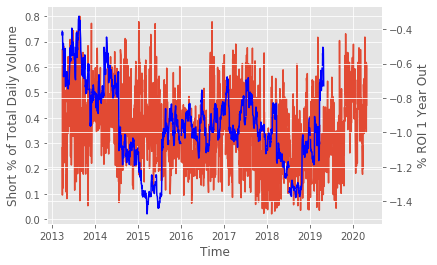

In [91]:
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('ggplot')

fig, ax = plt.subplots()

ax.plot(BIIB_final.index, BIIB_final['ShortPct'])
ax.set_ylabel('Short % of Total Daily Volume')
ax.set_xlabel('Time')

ax2 = ax.twinx()

ax2.plot(BIIB_final.index, BIIB_final['1y_forward_return'], color='b')
ax2.set_ylabel('% ROI 1 Year Out')

plt.show()

Wow - so I got down to it and it looks like the daily Short Volume trading data is soooooo volatile that it becomes super noisy.

I definitely want to clean up this project and make the code much more concise, but then I also want to look into what the industry standard is for short % interest. Right now it's just so gobsmackingly up and down and all over the place.

How can I find what the total volume of short shares outstanding is?

That's really what I need...not the daily total of short trades.

This was still an awesome exercise!

I'm going to revise this project still....open a new notebook and start fresh on that one, but keep this one up side by side so that I can look back to the learnings from this one

---
